In [0]:
### Applied Machine Learning Pipeline 95-845 #######
### Analysis of Bitcoin Profitability using exponential smoothening, RNN and LSTM ####
### Submitted by: Malvika Singh, Prakhar Mishra, Simran Handa
### The code proceeds through 
### 1. Data Preprocessing 
### 2. Training the model on RNN, predicting results for RNN  
### 3. Performing the above steps for LSTM.
### 4. Evaluated the models using RMSE 

### We have also performed Exploratory Data Analysis in R 
### Those results are attached in other section

In [216]:
## Importing required libraries for Data Preprocessing and Modeling
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import plotly.offline as py
import plotly.graph_objs as go
import numpy as np
import seaborn as sns
py.init_notebook_mode(connected=True)
%matplotlib inline

In [217]:
## Uploading data from source ####
from google.colab import files
uploaded = files.upload()

Saving data2.csv to data2 (3).csv


In [0]:
### Reading data 
import io
df2 = pd.read_csv(io.BytesIO(uploaded['data2.csv']))
df2.head()

,Timestamp,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
### Basic Information about dataset ###
## Exploratory Data Analysis ####
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 8 columns):
Timestamp            1048575 non-null int64
Open                 342169 non-null float64
High                 342169 non-null float64
Low                  342169 non-null float64
Close                342169 non-null float64
Volume (BTC)         342169 non-null float64
Volume (Currency)    342169 non-null float64
Weighted Price       342169 non-null float64
dtypes: float64(7), int64(1)
memory usage: 64.0 MB


In [0]:
### Data Description ####
df2.describe()

,Timestamp,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price
count,1.048575e+06,342169.000000,342169.000000,342169.000000,342169.000000,342169.000000,3.421690e+05,342169.000000
mean,1.356775e+09,229.456116,229.802477,229.064930,229.440478,16.274528,4.485655e+03,229.420213
std,1.816186e+07,271.716593,272.238257,271.141889,271.711086,48.128862,1.951265e+04,271.664754
min,1.325318e+09,3.800000,3.800000,3.800000,3.800000,0.000000,0.000000e+00,3.800000
25%,1.341047e+09,93.490000,93.540000,93.420000,93.490000,0.989954,9.900000e+01,93.482705
50%,1.356775e+09,121.110000,121.180000,121.000000,121.090000,3.026490,3.280394e+02,121.102502
75%,1.372504e+09,194.300000,194.460000,194.150000,194.300000,12.000000,1.782326e+03,194.299996
max,1.388232e+09,1163.000000,1163.000000,1162.990000,1163.000000,2958.477574,1.543035e+06,1162.999574


In [0]:
### Eliminating NA values since they do not contribute information to our analysis #####
df2.dropna()

,Timestamp,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.000000,4.390000
478,1325346600,4.39,4.39,4.39,4.39,48.000000,210.720000,4.390000
547,1325350740,4.50,4.57,4.50,4.57,37.862297,171.380337,4.526411
548,1325350800,4.58,4.58,4.58,4.58,9.000000,41.220000,4.580000
1224,1325391360,4.58,4.58,4.58,4.58,1.502000,6.879160,4.580000
...,...,...,...,...,...,...,...,...
1048570,1388232120,734.60,734.60,730.00,734.55,1.789687,1313.640757,734.005698
1048571,1388232180,734.55,734.55,730.71,730.71,0.110236,80.802051,732.991499
1048572,1388232240,734.40,734.40,730.51,730.51,0.554786,407.247985,734.063488
1048573,1388232300,730.51,733.63,730.51,731.10,0.620446,453.777190,731.372707


In [0]:
###### Data Pre Processing ########
###### Having month and year granularities ##########
df2['date'] = pd.to_datetime(df2['Timestamp'],unit='s').dt.date
df2['year'] = pd.to_datetime(df2['Timestamp'],unit='s').dt.year
df2 = df2.dropna()
df2.head()

,Timestamp,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price,date,year
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.000000,4.390000,2011-12-31,2011
478,1325346600,4.39,4.39,4.39,4.39,48.000000,210.720000,4.390000,2011-12-31,2011
547,1325350740,4.50,4.57,4.50,4.57,37.862297,171.380337,4.526411,2011-12-31,2011
548,1325350800,4.58,4.58,4.58,4.58,9.000000,41.220000,4.580000,2011-12-31,2011
1224,1325391360,4.58,4.58,4.58,4.58,1.502000,6.879160,4.580000,2012-01-01,2012


In [0]:
###### Checking for any more NAs that might have been introduced and eliminating them ######
df2.loc[df2.index.dropna()]

###### Adding parameter Competition from 
bitcoin = df2
bitcoin['Competition'] = 0
bitcoin.loc[bitcoin['year'] == 2011, ['Competition']] = 4
bitcoin.loc[bitcoin['year'] == 2012, ['Competition']] = 6
bitcoin.loc[bitcoin['year'] == 2013, ['Competition']] = 66
bitcoin.loc[bitcoin['year'] == 2014, ['Competition']] = 506
bitcoin.loc[bitcoin['year'] == 2015, ['Competition']] = 562
bitcoin.loc[bitcoin['year'] == 2016, ['Competition']] = 644
bitcoin.loc[bitcoin['year'] == 2017, ['Competition']] = 1335
bitcoin.head()

,Timestamp,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price,date,year,Competition
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.000000,4.390000,2011-12-31,2011,4
478,1325346600,4.39,4.39,4.39,4.39,48.000000,210.720000,4.390000,2011-12-31,2011,4
547,1325350740,4.50,4.57,4.50,4.57,37.862297,171.380337,4.526411,2011-12-31,2011,4
548,1325350800,4.58,4.58,4.58,4.58,9.000000,41.220000,4.580000,2011-12-31,2011,4
1224,1325391360,4.58,4.58,4.58,4.58,1.502000,6.879160,4.580000,2012-01-01,2012,6


In [0]:
## Adding parameter for Model_Price (Cost of bitcoin mining) as a part of data aggregation #####
## https://www.cesifo.org/DocDL/CESifo-Forum-2018-1-thum-bitcoin-march.pdf (cost of bitcoin)
## https://www.economicpolicyresearch.org/econ/2015/NSSR_WP_052015.pdf (cost of bitcoin)
bitcoin['Model_Price'] = 0
bitcoin['year_month'] = pd.to_datetime(bitcoin['Timestamp'],unit='s').dt.to_period('M')
bitcoin.loc[bitcoin['year'] == 2011, ['Model_Price']] = 32
bitcoin.loc[bitcoin['year'] == 2012, ['Model_Price']] = 65
bitcoin.loc[bitcoin['year_month'] == "2013-01", ['Model_Price']] = 68
bitcoin.loc[bitcoin['year_month'] == "2013-02", ['Model_Price']] = 68
bitcoin.loc[bitcoin['year_month'] == "2013-03", ['Model_Price']] = 68
bitcoin.loc[bitcoin['year_month'] == "2013-04", ['Model_Price']] = 68
bitcoin.loc[bitcoin['year_month'] == "2013-05", ['Model_Price']] = 68
bitcoin.loc[bitcoin['year_month'] == "2013-06", ['Model_Price']] = 68.73
bitcoin.loc[bitcoin['year_month'] == "2013-07", ['Model_Price']] = 79.83
bitcoin.loc[bitcoin['year_month'] == "2013-08", ['Model_Price']] = 96.36
bitcoin.loc[bitcoin['year_month'] == "2013-09", ['Model_Price']] = 126.01
bitcoin.loc[bitcoin['year_month'] == "2013-10", ['Model_Price']] = 199.575
bitcoin.loc[bitcoin['year_month'] == "2013-11", ['Model_Price']] = 296.25
bitcoin.loc[bitcoin['year_month'] == "2013-12", ['Model_Price']] = 684.72
bitcoin.loc[bitcoin['year_month'] == "2014-01", ['Model_Price']] = 848.03
bitcoin.loc[bitcoin['year_month'] == "2014-02", ['Model_Price']] = 626.196
bitcoin.loc[bitcoin['year_month'] == "2014-03", ['Model_Price']] = 584.2
bitcoin.loc[bitcoin['year_month'] == "2014-04", ['Model_Price']] = 435.926
bitcoin.loc[bitcoin['year_month'] == "2014-05", ['Model_Price']] = 559.79
bitcoin.loc[bitcoin['year_month'] == "2014-06", ['Model_Price']] = 621.0533
bitcoin.loc[bitcoin['year_month'] == "2014-07", ['Model_Price']] = 599.135
bitcoin.loc[bitcoin['year_month'] == "2014-08", ['Model_Price']] = 515.163
bitcoin.loc[bitcoin['year_month'] == "2014-09", ['Model_Price']] = 411.59
bitcoin.loc[bitcoin['year_month'] == "2014-10", ['Model_Price']] = 371.19
bitcoin.loc[bitcoin['year_month'] == "2014-11", ['Model_Price']] = 386.085
bitcoin.loc[bitcoin['year_month'] == "2014-12", ['Model_Price']] = 330.796
bitcoin.loc[bitcoin['year_month'] == "2015-01", ['Model_Price']] = 254.65
bitcoin.loc[bitcoin['year_month'] == "2015-02", ['Model_Price']] = 249.525
bitcoin.loc[bitcoin['year_month'] == "2015-03", ['Model_Price']] = 257.775
bitcoin.loc[bitcoin['year_month'] == "2015-04", ['Model_Price']] = 250.11
bitcoin.loc[bitcoin['year_month'] == "2015-05", ['Model_Price']] = 248.41
bitcoin.loc[bitcoin['year_month'] == "2015-06", ['Model_Price']] = 255.365
bitcoin.loc[bitcoin['year_month'] == "2015-07", ['Model_Price']] = 266.345
bitcoin.loc[bitcoin['year_month'] == "2015-08", ['Model_Price']] = 240.92
bitcoin.loc[bitcoin['year_month'] == "2015-09", ['Model_Price']] = 243.495
bitcoin.loc[bitcoin['year_month'] == "2015-10", ['Model_Price']] = 256.77
bitcoin.loc[bitcoin['year_month'] == "2015-11", ['Model_Price']] = 290.14
bitcoin.loc[bitcoin['year_month'] == "2015-12", ['Model_Price']] = 385.8633
bitcoin.loc[bitcoin['year_month'] == "2016-01", ['Model_Price']] = 412.41
bitcoin.loc[bitcoin['year_month'] == "2016-02", ['Model_Price']] = 396.65
bitcoin.loc[bitcoin['year_month'] == "2016-03", ['Model_Price']] = 417.27
bitcoin.loc[bitcoin['year_month'] == "2016-04", ['Model_Price']] = 440.273
bitcoin.loc[bitcoin['year_month'] == "2016-05", ['Model_Price']] = 443.72
bitcoin.loc[bitcoin['year_month'] == "2016-06", ['Model_Price']] = 674.7
bitcoin.loc[bitcoin['year_month'] == "2016-07", ['Model_Price']] = 687.56
bitcoin.loc[bitcoin['year_month'] == "2016-08", ['Model_Price']] = 687.22
bitcoin.loc[bitcoin['year_month'] == "2016-09", ['Model_Price']] = 752.255
bitcoin.loc[bitcoin['year_month'] == "2016-10", ['Model_Price']] = 824.86
bitcoin.loc[bitcoin['year_month'] == "2016-11", ['Model_Price']] = 863.965
bitcoin.loc[bitcoin['year_month'] == "2016-12", ['Model_Price']] = 982.056
bitcoin.loc[bitcoin['year_month'] == "2017-01", ['Model_Price']] = 1175.525
bitcoin.loc[bitcoin['year_month'] == "2017-02", ['Model_Price']] = 1389.88
bitcoin.loc[bitcoin['year_month'] == "2017-03", ['Model_Price']] = 1542.01
bitcoin.loc[bitcoin['year_month'] == "2017-04", ['Model_Price']] = 1679.52
bitcoin.loc[bitcoin['year_month'] == "2017-05", ['Model_Price']] = 1681.695
bitcoin.loc[bitcoin['year_month'] == "2017-06", ['Model_Price']] = 2239.49
bitcoin.loc[bitcoin['year_month'] == "2017-07", ['Model_Price']] = 2548.427
bitcoin.loc[bitcoin['year_month'] == "2017-08", ['Model_Price']] = 2917.47
bitcoin.loc[bitcoin['year_month'] == "2017-09", ['Model_Price']] = 3263.3
bitcoin.loc[bitcoin['year_month'] == "2017-10", ['Model_Price']] = 4051.67
bitcoin.loc[bitcoin['year_month'] == "2017-11", ['Model_Price']] = 4367.055
bitcoin.loc[bitcoin['year_month'] == "2017-12", ['Model_Price']] = 5579.17
bitcoin.head()

,Timestamp,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price,date,year,Competition,Model_Price,year_month
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.000000,4.390000,2011-12-31,2011,4,32.0,2011-12
478,1325346600,4.39,4.39,4.39,4.39,48.000000,210.720000,4.390000,2011-12-31,2011,4,32.0,2011-12
547,1325350740,4.50,4.57,4.50,4.57,37.862297,171.380337,4.526411,2011-12-31,2011,4,32.0,2011-12
548,1325350800,4.58,4.58,4.58,4.58,9.000000,41.220000,4.580000,2011-12-31,2011,4,32.0,2011-12
1224,1325391360,4.58,4.58,4.58,4.58,1.502000,6.879160,4.580000,2012-01-01,2012,6,65.0,2012-01


In [0]:
##Calculating the ratio of the market price and the weighted price
bitcoin['Price Ratio'] =  (bitcoin['Weighted Price'] / bitcoin['Model_Price'] ) 
bitcoin.head()

,Timestamp,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price,date,year,Competition,Model_Price,year_month,Price Ratio
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.000000,4.390000,2011-12-31,2011,4,32.0,2011-12,0.137187
478,1325346600,4.39,4.39,4.39,4.39,48.000000,210.720000,4.390000,2011-12-31,2011,4,32.0,2011-12,0.137187
547,1325350740,4.50,4.57,4.50,4.57,37.862297,171.380337,4.526411,2011-12-31,2011,4,32.0,2011-12,0.141450
548,1325350800,4.58,4.58,4.58,4.58,9.000000,41.220000,4.580000,2011-12-31,2011,4,32.0,2011-12,0.143125
1224,1325391360,4.58,4.58,4.58,4.58,1.502000,6.879160,4.580000,2012-01-01,2012,6,65.0,2012-01,0.070462


In [0]:
##Add a column that puts in the status for the hazard
bitcoin['Status'] = 0
bitcoin.loc[bitcoin['Price Ratio'] >= 1, ['Status']] = 1
bitcoin.loc[bitcoin['Price Ratio'] < 1,['Status']] = 0

##Calculating the volatility
bitcoin['Volatility'] = 0
bitcoin['Volatility'] = bitcoin['High'] - bitcoin['Low']

bitcoin.head()

,Timestamp,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price,date,year,Competition,Model_Price,year_month,Price Ratio,Status,Volatility
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.000000,4.390000,2011-12-31,2011,4,32.0,2011-12,0.137187,0,0.00
478,1325346600,4.39,4.39,4.39,4.39,48.000000,210.720000,4.390000,2011-12-31,2011,4,32.0,2011-12,0.137187,0,0.00
547,1325350740,4.50,4.57,4.50,4.57,37.862297,171.380337,4.526411,2011-12-31,2011,4,32.0,2011-12,0.141450,0,0.07
548,1325350800,4.58,4.58,4.58,4.58,9.000000,41.220000,4.580000,2011-12-31,2011,4,32.0,2011-12,0.143125,0,0.00
1224,1325391360,4.58,4.58,4.58,4.58,1.502000,6.879160,4.580000,2012-01-01,2012,6,65.0,2012-01,0.070462,0,0.00


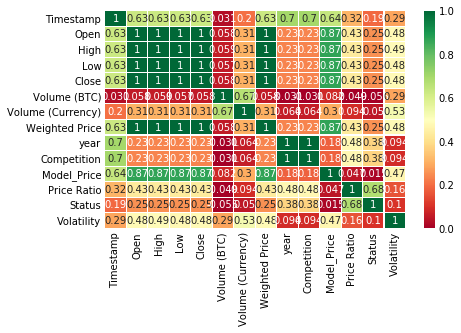

In [0]:
sns.heatmap(bitcoin.corr(), annot=True, cmap='RdYlGn', linewidths=0.1, vmin=0)


In [0]:
corr = bitcoin.corr()
columns = np.full((16,), True, dtype=bool)
## Code adapted from https://towardsdatascience.com/feature-selection-correlation-and-p-value-da8921bfb3cf for correlation matrices ###
for i in range(16):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.9:
            if columns[j]:
                columns[j] = False
selected_columns = bitcoin.columns[columns]
dt = bitcoin
dt = dt[selected_columns]
dt.head()

,Timestamp,Open,Volume (BTC),Volume (Currency),date,Competition,Model_Price,year_month,Price Ratio,Status,Volatility
0,1325317920,4.39,0.455581,2.000000,2011-12-31,4,32.0,2011-12,0.137187,0,0.00
478,1325346600,4.39,48.000000,210.720000,2011-12-31,4,32.0,2011-12,0.137187,0,0.00
547,1325350740,4.50,37.862297,171.380337,2011-12-31,4,32.0,2011-12,0.141450,0,0.07
548,1325350800,4.58,9.000000,41.220000,2011-12-31,4,32.0,2011-12,0.143125,0,0.00
1224,1325391360,4.58,1.502000,6.879160,2012-01-01,6,65.0,2012-01,0.070462,0,0.00


In [0]:
#### Xgboost Method #####
#### Loading libraries for running the model ###
import seaborn as sns
import matplotlib.pyplot as plt
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

In [219]:
data = bitcoin
data['date'] = pd.to_datetime(data['date'], errors='coerce')

data['date'] = data['date'].dt.tz_localize(None)
data = data.groupby([pd.Grouper(key='date', freq='H')]).first().reset_index()
data = data.set_index('date')
data = data[['Price Ratio']]
data['Price Ratio'].fillna(method='ffill', inplace=True)
data.head()

,Price Ratio
date,
2011-12-31 00:00:00,0.137187
2011-12-31 01:00:00,0.137187
2011-12-31 02:00:00,0.137187
2011-12-31 03:00:00,0.137187
2011-12-31 04:00:00,0.137187


In [0]:
split_date = '25-Jan-2013'
data_train = data.loc[data.index <= split_date].copy()
data_test = data.loc[data.index > split_date].copy()

In [0]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [0]:
X_train, y_train = create_features(data_train, label='Price Ratio')
X_test, y_test = create_features(data_test, label='Price Ratio')

In [223]:
import xgboost as xgb
from xgboost import plot_importance, plot_tree

model =  xgb.XGBRegressor(objective ='reg:linear',min_child_weight=10, booster='gbtree', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 100)
model.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False)

[16:18:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=5, min_child_weight=10, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [0]:
data_test['Price_Ratio_Prediction'] = model.predict(X_test)
data_all = pd.concat([data_test, data_train], sort=False)

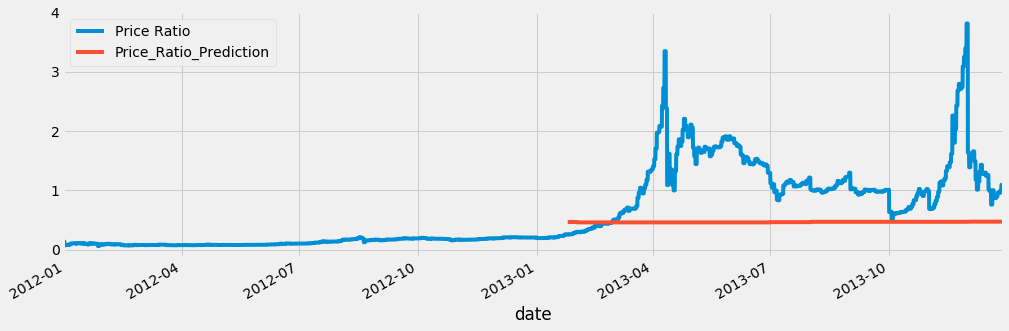

In [225]:
_ = data_all[['Price Ratio','Price_Ratio_Prediction']].plot(figsize=(15, 5))

In [226]:
mean_squared_error(y_true=data_test['Price Ratio'],
                   y_pred=data_test['Price_Ratio_Prediction'])

0.8427317942509599

In [0]:
######### RNN #########
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
import warnings
warnings.filterwarnings("ignore")



In [0]:
df = bitcoin[['Price Ratio', 'Volatility', 'Competition','Timestamp','Volume (BTC)']].copy()
bit_data = df
bit_data["date"]=pd.to_datetime(bit_data["Timestamp"],unit="s").dt.date
group=bit_data.groupby("date")
data=group["Price Ratio"].mean()

In [0]:
price_train=data.iloc[:len(data)-50]
price_test=data.iloc[len(price_train):]

In [0]:
#feature scaling (set values between 0-1)
price_train=np.array(price_train)
price_train=price_train.reshape(price_train.shape[0],1)
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
price_scaled=scaler.fit_transform(price_train)

In [0]:
timestep=100
x_train=[]
y_train=[]

for i in range(timestep,price_scaled.shape[0]):
    x_train.append(price_scaled[i-timestep:i,0])
    y_train.append(price_scaled[i,0])

x_train,y_train=np.array(x_train),np.array(y_train)
x_train=x_train.reshape(x_train.shape[0],x_train.shape[1],1) #reshaped for RNN
print("x_train shape= ",x_train.shape)
print("y_train shape= ",y_train.shape)

x_train shape=  (579, 100, 1)
y_train shape=  (579,)


In [0]:
## Some parts of this code are adapted from https://github.com/kaggle/docker-python and Stackoverflow
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Dropout,Flatten

regressor=Sequential()
#first RNN layer
regressor.add(SimpleRNN(128,activation="relu",return_sequences=True,input_shape=(x_train.shape[1],1)))
regressor.add(Dropout(0.25))
#second RNN layer
regressor.add(SimpleRNN(256,activation="relu",return_sequences=True))
regressor.add(Dropout(0.25))
#third RNN layer
regressor.add(SimpleRNN(512,activation="relu",return_sequences=True))
regressor.add(Dropout(0.35))
#fourth RNN layer
regressor.add(SimpleRNN(256,activation="relu",return_sequences=True))
regressor.add(Dropout(0.25))
#fifth RNN layer
regressor.add(SimpleRNN(128,activation="relu",return_sequences=True))
regressor.add(Dropout(0.25))
#convert the matrix to 1-line
regressor.add(Flatten())
#output layer
regressor.add(Dense(1))

regressor.compile(optimizer="adam",loss="mean_squared_error")
regressor.fit(x_train,y_train,epochs=100,batch_size=64)

Epoch 1/100
579/579 [==============================] - 16s 28ms/step - loss: 0.0742
Epoch 2/100
579/579 [==============================] - 13s 22ms/step - loss: 0.0150
Epoch 3/100
579/579 [==============================] - 13s 22ms/step - loss: 0.0077
Epoch 4/100
579/579 [==============================] - 13s 22ms/step - loss: 0.0067
Epoch 5/100
579/579 [==============================] - 13s 22ms/step - loss: 0.0057
Epoch 6/100
579/579 [==============================] - 13s 22ms/step - loss: 0.0064
Epoch 7/100
579/579 [==============================] - 13s 22ms/step - loss: 0.0050
Epoch 8/100
579/579 [==============================] - 13s 22ms/step - loss: 0.0104
Epoch 9/100
579/579 [==============================] - 13s 22ms/step - loss: 0.0085
Epoch 10/100
579/579 [==============================] - 13s 22ms/step - loss: 0.0042
Epoch 11/100
579/579 [==============================] - 13s 22ms/step - loss: 0.0044
Epoch 12/100
579/579 [==============================] - 13s 22ms/step - lo

In [0]:
## Transforming inputs and reshaping them to feed in neural nets ###
inputs=data[len(data)-len(price_test)-timestep:]
inputs=inputs.values.reshape(-1,1)
inputs=scaler.transform(inputs)

In [0]:
## Some parts of this code are adapted from https://github.com/kaggle/docker-python and Stackoverflow
x_test=[]
for i in range(timestep,inputs.shape[0]):
    x_test.append(inputs[i-timestep:i,0])
x_test=np.array(x_test)
x_test=x_test.reshape(x_test.shape[0],x_test.shape[1],1)

In [0]:
## Making Predictions #####
predicted_data=regressor.predict(x_test)
predicted_data=scaler.inverse_transform(predicted_data)

In [0]:
data_test=np.array(price_test)
data_test=data_test.reshape(len(data_test),1)

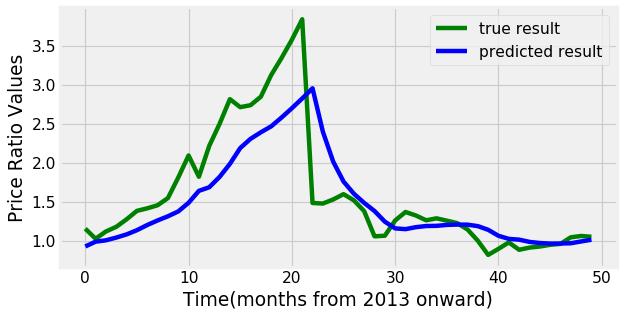

In [207]:
## Plotting predicted and actual time series for test data ##########
plt.figure(figsize=(8,4), dpi=80, facecolor='w', edgecolor='k')
plt.plot(data_test,color="g",label="true result")
plt.plot(predicted_data,color="b",label="predicted result")
plt.legend()
plt.xlabel("Time(months from 2013 onward)")
plt.ylabel("Price Ratio Values")
plt.grid(True)
plt.show()

In [0]:
### RMSE for RNN ##########
from sklearn.metrics import mean_squared_error
from math import sqrt

rms = sqrt(mean_squared_error(data_test, predicted_data))
print(rms)

0.6658086436468782


In [196]:
######## Comparison with Long Short Term Memory (LSTM) neural net  ##########
from sklearn.metrics import mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout,Flatten

model=Sequential()

model.add(LSTM(10,input_shape=(None,1),activation="relu"))

model.add(Dense(1))

model.compile(loss="mean_squared_error",optimizer="adam")

model.fit(x_train,y_train,epochs=100,batch_size=32)

Epoch 1/100
579/579 [==============================] - 4s 7ms/step - loss: 0.0587
Epoch 2/100
579/579 [==============================] - 1s 2ms/step - loss: 0.0429
Epoch 3/100
579/579 [==============================] - 1s 2ms/step - loss: 0.0316
Epoch 4/100
579/579 [==============================] - 1s 2ms/step - loss: 0.0242
Epoch 5/100
579/579 [==============================] - 1s 2ms/step - loss: 0.0193
Epoch 6/100
579/579 [==============================] - 1s 2ms/step - loss: 0.0154
Epoch 7/100
579/579 [==============================] - 1s 2ms/step - loss: 0.0115
Epoch 8/100
579/579 [==============================] - 1s 2ms/step - loss: 0.0082
Epoch 9/100
579/579 [==============================] - 1s 2ms/step - loss: 0.0061
Epoch 10/100
579/579 [==============================] - 1s 2ms/step - loss: 0.0054
Epoch 11/100
579/579 [==============================] - 1s 2ms/step - loss: 0.0051
Epoch 12/100
579/579 [==============================] - 1s 2ms/step - loss: 0.0049
Epoch 13/100


In [0]:
### Scaling and transforming data to feed in LSTM #######
inputs=data[len(data)-len(price_test)-timestep:]
inputs=inputs.values.reshape(-1,1)
inputs=scaler.transform(inputs)

In [0]:
x_test=[]
for i in range(timestep,inputs.shape[0]):
    x_test.append(inputs[i-timestep:i,0])
x_test=np.array(x_test)
x_test=x_test.reshape(x_test.shape[0],x_test.shape[1],1)

In [0]:
## Making Predictions using LSTM ####
predicted_data=model.predict(x_test)
predicted_data=scaler.inverse_transform(predicted_data)

In [0]:
data_test=np.array(price_test)
data_test=data_test.reshape(len(data_test),1)

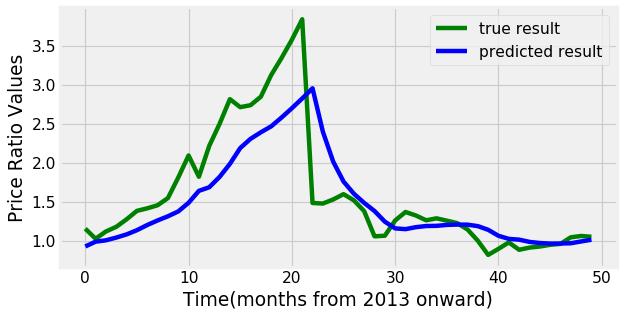

In [205]:
plt.figure(figsize=(8,4), dpi=80, facecolor='w', edgecolor='k')
plt.plot(data_test,color="g",label="true result")
plt.plot(predicted_data,color="b",label="predicted result")
plt.legend()
plt.xlabel("Time(months from 2013 onward)")
plt.ylabel("Price Ratio Values")
plt.grid(True)
plt.show()

In [206]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rms = sqrt(mean_squared_error(data_test, predicted_data))
print(rms)

0.43724089002370287
